In [1]:
import numpy as np
from hcipy import *
import misc_funs as misc

spatial_resolution = focal_length * wavelength / pupil_diameter
iwa = 2 * spatial_resolution
owa = 12 * spatial_resolution
offset = 1 * spatial_resolution

influence_functions = make_xinetics_influence_functions(pupil_grid, num_actuators_across, actuator_spacing)
dm1 = DeformableMirror(influence_functions)
dm2 = DeformableMirror(influence_functions)

distance_between_dms = 200e-3 # m
prop_between_dms = FresnelPropagator(pupil_grid, distance_between_dms)


dark_zone_twosided = circular_aperture(2 * owa)(focal_grid)
dark_zone_twosided -= circular_aperture(2 * iwa)(focal_grid)
dark_zone_twosided = dark_zone_twosided.astype('bool')

In [6]:
coronagraph = PerfectCoronagraph(aperture, order=6)

tip_tilt = make_zernike_basis(3, pupil_diameter, pupil_grid, starting_mode=2)
aberration = SurfaceAberration(pupil_grid, aberration_ptv, pupil_diameter, remove_modes=tip_tilt, exponent=-3)
aberration_distance = 100e-3 # m
aberration_at_distance = SurfaceAberrationAtDistance(aberration, aberration_distance)


In [22]:
np.array(im.intensity.shaped)

array([[3.99590220e-05, 1.00677132e-05, 3.15949336e-05, ...,
        1.84416444e-04, 2.84803582e-04, 1.28161826e-04],
       [2.20346313e-06, 1.46983110e-04, 7.32926947e-05, ...,
        2.90254066e-04, 5.85111917e-04, 3.32098372e-04],
       [1.13075526e-04, 3.71958327e-04, 2.49148860e-04, ...,
        1.68998159e-04, 3.70732084e-04, 1.83946068e-04],
       ...,
       [5.96271632e-05, 1.04917919e-04, 9.39803830e-05, ...,
        7.39194733e-05, 2.71752618e-04, 4.06480674e-04],
       [1.42606727e-04, 1.27867585e-04, 3.10377672e-04, ...,
        2.36401940e-05, 2.46616696e-04, 3.55256314e-04],
       [2.34443342e-04, 3.64921309e-04, 5.62060604e-04, ...,
        9.55187252e-05, 6.80151841e-05, 1.73295493e-04]])

In [ ]:
def CORO():
    def __init__(self,
                 wavelength=None, 
                 npsf=64, psf_pixelscale=13e-6*u.m/u.pix, psf_pixelscale_lamD=None, interp_order=3,
                 offset=(0,0), 
                 use_fpm=True, 
                 use_fieldstop=True, 
                 use_pupil_defocus=True, 
                 use_opds=False, 
                 dm1_ref=np.zeros((48,48)),
                 dm2_ref=np.zeros((48,48)),
                 polaxis=0,
                 use_noise=False,
                 texp=60*u.s,
                 star_flux=1e5*u.photon/u.m**2/u.s):
        
        pupil_diameter = 7e-3 # m
        wavelength = 700e-9 # m
        focal_length = 500e-3 # m

        num_actuators_across = 32
        actuator_spacing = 1.05 / 32 * pupil_diameter
        aberration_ptv = 0.02 * wavelength # m

        # Create grids
        pupil_grid = make_pupil_grid(128, pupil_diameter * 1.2)
        focal_grid = make_focal_grid(2, 16, spatial_resolution=spatial_resolution)
        prop = FraunhoferPropagator(pupil_grid, focal_grid, focal_length)

        # Create aperture and dark zone
        aperture = Field(np.exp(-(pupil_grid.as_('polar').r / (0.5 * pupil_diameter))**30), pupil_grid)
        
        self.dm1 = DeformableMirror(influence_functions)
        self.dm2 = DeformableMirror(influence_functions)
        
        self.use_opds = use_opds
        
    def add_dm1(self, command):
        self.dm1 += command
        
    def add_dm2(self, command):
        self.dm2 += command
        
    def set_dm1(self, command):
        self.dm1 = command
        
    def set_dm2(self, command):
        self.dm2 = command
        
    def snap(self):
        wf = Wavefront(aperture, wavelength)
        if self.use_opds:
            wf = aberration_at_distance(wf)

        wf_post_dms = prop_between_dms.backward(dm2(prop_between_dms.forward(dm1(wf))))
        img = prop(coronagraph(wf_post_dms))

    return np.array(img.intensity.shaped)

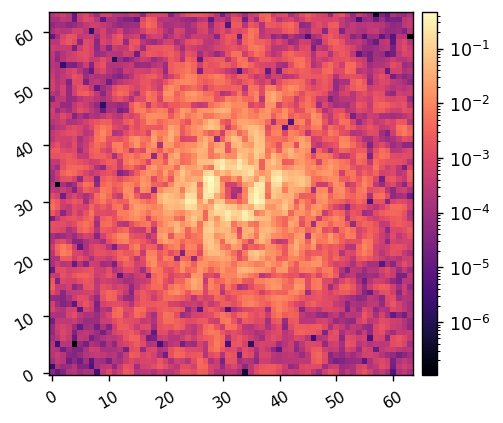

In [24]:
def snap(actuators=None, include_aberration=True):
    if actuators is not None:
        dm1.actuators = actuators[:len(influence_functions)]
        dm2.actuators = actuators[len(influence_functions):]

    wf = Wavefront(aperture, wavelength)
    if include_aberration:
        wf = aberration_at_distance(wf)

    wf_post_dms = prop_between_dms.backward(dm2(prop_between_dms.forward(dm1(wf))))
    img = prop(coronagraph(wf_post_dms))

    return np.array(img.intensity.shaped)

im = snap()
misc.imshow1(im, lognorm=True)